In [1]:
#| echo: false
#| label: 024_imports
import os
from math import inf
import numpy as np
import warnings
if not os.path.exists('./figures'):
    os.makedirs('./figures')
warnings.filterwarnings("ignore")

This chapter demonstrates hyperparameter tuning for `river`'s `Hoeffding Adaptive Tree Regressor` with the Friedman drift data set [[SOURCE]](https://riverml.xyz/0.18.0/api/datasets/synth/FriedmanDrift/). The `Hoeffding Adaptive Tree Regressor` is a decision tree that uses the Hoeffding bound to limit the number of splits evaluated at each node. The `Hoeffding Adaptive Tree Regressor` is a regression tree, i.e., it predicts a real value for each sample. The `Hoeffding Adaptive Tree Regressor` is a drift aware model, i.e., it can handle concept drifts.

## The Friedman Drift Data Set

We will use the Friedman synthetic dataset with concept drifts [[SOURCE]](https://riverml.xyz/0.18.0/api/datasets/synth/FriedmanDrift/). Each observation is composed of ten features. Each feature value is sampled uniformly in [0, 1]. Only the first five features are relevant. The target is defined by different functions depending on the type of the drift. Global Recurring Abrupt drift will be used, i.e., the concept drift appears over the whole instance space. There are two points of concept drift. At the second point of drift the old concept reoccurs.

The following parameters are used to generate and handle the data set:

* horizon: The prediction horizon in hours.
* n_samples: The number of samples in the data set.
* p_1: The position of the first concept drift.
* p_2: The position of the second concept drift.
* position: The position of the concept drifts.
* n_train: The number of samples used for training.

We will use `spotriver`'s `convert_to_df` function [[SOURCE]](https://github.com/sequential-parameter-optimization/spotriver/blob/main/src/spotriver/utils/data_conversion.py) to convert the `river` data set to a `pandas` data frame.
Then we add column names x1 until x10 to the first 10 columns of the dataframe and the column name y to the last column of the dataframe.

In [2]:
#| label: 024_data_set

from river.datasets import synth
import pandas as pd
import numpy as np
from spotriver.utils.data_conversion import convert_to_df

seed = 123
shuffle = True
n_train = 6_000
n_test = 4_000
n_samples = n_train + n_test
target_column = "y"

dataset = synth.FriedmanDrift(
   drift_type='gra',
   position=(n_train/4, n_train/2),
   seed=123
)

train = convert_to_df(dataset, n_total=n_train)
train.columns = [f"x{i}" for i in range(1, 11)] + [target_column]


dataset = synth.FriedmanDrift(
   drift_type='gra',
   position=(n_test/4, n_test/2),
   seed=123
)
test = convert_to_df(dataset, n_total=n_test)
test.columns = [f"x{i}" for i in range(1, 11)] + [target_column]

## Setup

Before we consider the detailed experimental setup, we select the parameters that affect run time, initial design size, size of the data set, and the experiment name.

* `MAX_TIME`: The maximum run time in seconds for the hyperparameter tuning process.
* `INIT_SIZE`: The initial design size for the hyperparameter tuning process.
* `PREFIX`: The prefix for the experiment name.

::: {.callout-caution}
### Caution: Run time and initial design size should be increased for real experiments

* `MAX_TIME` is set to one minute for demonstration purposes. For real experiments, this should be increased to at least 1 hour.
* `INIT_SIZE` is set to 5 for demonstration purposes. For real experiments, this should be increased to at least 10.
:::

The `oml_grace_period` defines the number of observations that are used for the initial training of the model.

The `weight_coeff` defines a multiplier for the results: results are multiplied by (step/n_steps)**weight_coeff, where n_steps is the total number of iterations.
Results from the beginning have a lower weight than results from the end if weight_coeff > 1. If weight_coeff == 0, all results have equal weight. Note, that the `weight_coeff` is only used internally for the tuner and does not affect the results that are used for the evaluation or comparisons.

The `weights` provide a flexible way to define specific requirements, e.g., if the memory is more important than the time, the weight for the memory can be increased.

The `TENSORBOARD_CLEAN` argument is set to `True` to archive the TensorBoard folder if it already exists. This is useful if you want to start a hyperparameter tuning process from scratch.
If you want to continue a hyperparameter tuning process, set `TENSORBOARD_CLEAN` to `False`. Then the TensorBoard folder will not be archived and the old and new TensorBoard files will shown in the TensorBoard dashboard.

## SelectSelect Model (`algorithm`) and `core_model_hyper_dict`

`spotpython` hyperparameter tuning approach uses two components:

1. a model (class) and 
2. an associated hyperparameter dictionary. 

Here, the `river` model class `HoeffdingAdaptiveTreeRegressor` [[SOURCE]](https://riverml.xyz/dev/api/tree/HoeffdingAdaptiveTreeRegressor/) is selected.

The corresponding hyperparameters are loaded from the associated dictionary, which is stored as a JSON file [[SOURCE]](https://github.com/sequential-parameter-optimization/spotriver/blob/main/src/spotriver/data/river_hyper_dict.json). The JSON file contains hyperparameter type information, names, and bounds. 

The method `add_core_model_to_fun_control` adds the model and the hyperparameter dictionary to the `fun_control` dictionary.

Alternatively, you can load a local hyper_dict. Simply set `river_hyper_dict.json` as the filename. If `filename`is set to `None`, which is the default, the hyper_dict [[SOURCE]](https://github.com/sequential-parameter-optimization/spotriver/blob/main/src/spotriver/data/river_hyper_dict.json) is loaded from the `spotriver` package.

We use the `StandardScaler` [[SOURCE]](https://riverml.xyz/dev/api/preprocessing/StandardScaler/) from `river` as the preprocessing model. The `StandardScaler` is used to standardize the data set, i.e., it has zero mean and unit variance.

## Objective Function

### The Objective Function {#sec-the-objective-function-13}

The objective function `fun_oml_horizon` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotriver/blob/main/src/spotriver/fun/hyperriver.py) is selected next.

## Selection of the Objective (Loss) Function

The `metric_sklearn` is used for the sklearn based evaluation via `eval_oml_horizon` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotriver/blob/main/src/spotriver/evaluation/eval_bml.py). Here we use the ` mean_absolute_error` [[SOURCE]](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) as the objective function.

:::{.callout-note}
#### Note: Additional metrics
`spotriver` also supports additional metrics. For example, the `metric_river` is used for the river based evaluation via `eval_oml_iter_progressive` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotriver/blob/main/src/spotriver/evaluation/eval_oml.py). The `metric_river` is implemented to simulate the behaviour of the "original" `river` metrics.
:::

`spotriver` provides information about the model' s score (metric), memory, and time.
The hyperparamter tuner requires a single objective.
Therefore, a weighted sum of the metric, memory, and time is computed. The weights are defined in the `weights` array.

:::{.callout-note}
#### Note: Weights
The `weights` provide a flexible way to define specific requirements, e.g., if the memory is more important than the time, the weight for the memory can be increased.
:::

The `oml_grace_period` defines the number of observations that are used for the initial training of the model. The `step` defines the iteration number at which to yield results. This only takes into account the predictions, and not the training steps.  The `weight_coeff` defines a multiplier for the results: results are multiplied by (step/n_steps)**weight_coeff, where n_steps is the total number of iterations. 
Results from the beginning have a lower weight than results from the end if weight_coeff > 1. If weight_coeff == 0, all results have equal weight. Note, that the `weight_coeff` is only used internally for the tuner and does not affect the results that are used for the evaluation or comparisons.

In [3]:
from spotpython.utils.init import fun_control_init, design_control_init, surrogate_control_init, optimizer_control_init
from spotriver.fun.hyperriver import HyperRiver
from spotGUI.tuner.spotRun import get_metric_sklearn, get_prep_model, get_core_model_from_name
from spotpython.hyperparameters.values import (
    add_core_model_to_fun_control,
)
from spotriver.hyperdict.river_hyper_dict import RiverHyperDict

PREFIX = "024"
# core_model_name = "tree.HoeffdingAdaptiveTreeRegressor"
core_model_name = "tree.HoeffdingTreeRegressor"
fun_evals = inf
horizon = 7*24
max_time = 10
init_size = 10
metric_sklearn_name = "mean_absolute_error"
prep_model_name = "StandardScaler"
hyperdict = RiverHyperDict

oml_grace_period = horizon
weight_coeff = 1.0
weights = np.array([1, 0.01, 0.01])

fun = HyperRiver().fun_oml_horizon

fun_control = fun_control_init(
    PREFIX=PREFIX,
    TENSORBOARD_CLEAN=True,
    core_model_name=core_model_name,
    fun_evals=fun_evals,
    horizon=horizon,
    max_time=max_time,
    metric_sklearn=get_metric_sklearn(metric_sklearn_name),
    metric_sklearn_name=metric_sklearn_name,
    noise=True,
    oml_grace_period=oml_grace_period,
    prep_model_name=prep_model_name,
    prep_model=get_prep_model(prep_model_name),
    seed=seed,
    target_column=target_column,
    test=test,
    train=train,
    weight_coeff=weight_coeff,
    weights=weights,)

coremodel, core_model_instance = get_core_model_from_name(core_model_name)
add_core_model_to_fun_control(
    core_model=core_model_instance,
    fun_control=fun_control,
    hyper_dict=hyperdict,
    filename=None,
)

design_control = design_control_init(
    init_size=init_size,
)

surrogate_control = surrogate_control_init(
    noise=True,
    n_theta=2,
    min_Lambda=1e-3,
    max_Lambda=10,
)

optimizer_control = optimizer_control_init()

Seed set to 123
Seed set to 123


Moving TENSORBOARD_PATH: runs/ to TENSORBOARD_PATH_OLD: runs_OLD/runs_2024_06_06_23_01_45
Created spot_tensorboard_path: runs/spot_logs/024_p040025_2024-06-06_23-01-45 for SummaryWriter()


In [4]:
# from spotpython.hyperparameters.values import modify_hyper_parameter_levels
# levels = ["LinearRegression"]
# modify_hyper_parameter_levels(fun_control, "leaf_model", levels)


In [5]:
from spotpython.utils.eda import gen_design_table
from spotpython.spot import spot
print(gen_design_table(fun_control))


| name                   | type   | default          |   lower |    upper | transform              |
|------------------------|--------|------------------|---------|----------|------------------------|
| grace_period           | int    | 200              |  10     | 1000     | None                   |
| max_depth              | int    | 20               |   2     |   20     | transform_power_2_int  |
| delta                  | float  | 1e-07            |   1e-08 |    1e-06 | None                   |
| tau                    | float  | 0.05             |   0.01  |    0.1   | None                   |
| leaf_prediction        | factor | mean             |   0     |    2     | None                   |
| leaf_model             | factor | LinearRegression |   0     |    2     | None                   |
| model_selector_decay   | float  | 0.95             |   0.9   |    0.99  | None                   |
| splitter               | factor | EBSTSplitter     |   0     |    2     | None           

### Run the `Spot` Optimizer

The class `Spot` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotpython/blob/main/src/spotpython/spot/spot.py) is the hyperparameter tuning workhorse. It is initialized with the following parameters:

* `fun`: the objective function
* `fun_control`: the dictionary with the control parameters for the objective function
* `design`: the experimental design
* `design_control`: the dictionary with the control parameters for the experimental design
* `surrogate`: the surrogate model
* `surrogate_control`: the dictionary with the control parameters for the surrogate model
* `optimizer`: the optimizer
* `optimizer_control`: the dictionary with the control parameters for the optimizer

:::{.callout-note}
#### Note: Total run time
 The total run time may exceed the specified `max_time`, because the initial design (here: `init_size` = INIT_SIZE as specified above) is always evaluated, even if this takes longer than `max_time`.
:::

In [6]:

spot_tuner = spot.Spot(
    fun=fun,
    fun_control=fun_control,
    design_control=design_control,
    surrogate_control=surrogate_control,
    optimizer_control=optimizer_control,
)
res = spot_tuner.run()

spotpython tuning: 3.197954674502633 [----------] 1.01% 
spotpython tuning: 2.238007041963859 [----------] 1.81% 
spotpython tuning: 2.238007041963859 [----------] 2.17% 
spotpython tuning: 2.238007041963859 [----------] 2.34% 
spotpython tuning: 2.238007041963859 [----------] 2.83% 
spotpython tuning: 2.238007041963859 [----------] 3.00% 
spotpython tuning: 2.238007041963859 [----------] 3.18% 
spotpython tuning: 2.237993230533375 [----------] 4.56% 
spotpython tuning: 2.237993230533375 [#---------] 5.41% 
spotpython tuning: 2.237993230533375 [#---------] 6.05% 
spotpython tuning: 2.237993230533375 [#---------] 6.77% 
spotpython tuning: 2.237993230533375 [#---------] 8.43% 
spotpython tuning: 2.237993230533375 [#---------] 9.69% 
spotpython tuning: 2.157765431506081 [#---------] 11.18% 
spotpython tuning: 2.157765431506081 [#---------] 11.80% 
spotpython tuning: 2.157765431506081 [#########-] 87.83% 
spotpython tuning: 2.157765431506081 [##########] 100.00% Done...



## Results

### TensorBoard {#sec-tensorboard-10}

Now we can start TensorBoard in the background with the following command, where `./runs` is the default directory for the TensorBoard log files:

```{raw}
tensorboard --logdir="./runs"
```

:::{.callout-tip}
#### Tip: TENSORBOARD_PATH
The TensorBoard path can be printed with the following command:

In [7]:
#| label: 024_tensorboard_path
from spotpython.utils.init import get_tensorboard_path
get_tensorboard_path(fun_control)

'runs/'

In [8]:
#| label: 024_print_results
spot_tuner.print_results(print_screen=False)

[['grace_period', 41.0],
 ['max_depth', 11.0],
 ['delta', 1e-06],
 ['tau', 0.029762022410147075],
 ['leaf_prediction', 1.0],
 ['leaf_model', 0.0],
 ['model_selector_decay', 0.922400782896156],
 ['splitter', 1.0],
 ['min_samples_split', 8.0],
 ['binary_split', 1.0],
 ['max_size', 457.44480300160893],
 ['memory_estimate_period', 6.0],
 ['stop_mem_management', 1.0],
 ['remove_poor_attrs', 1.0],
 ['merit_preprune', 0.0]]

The tuned hyperparameters can be obtained as a dictionary with the following command:

In [9]:
from spotpython.hyperparameters.values import get_tuned_hyperparameters
get_tuned_hyperparameters(spot_tuner, fun_control)

{'grace_period': 41.0,
 'max_depth': 11.0,
 'delta': 1e-06,
 'tau': 0.029762022410147075,
 'leaf_prediction': 'model',
 'leaf_model': 'LinearRegression',
 'model_selector_decay': 0.922400782896156,
 'splitter': 'TEBSTSplitter',
 'min_samples_split': 8.0,
 'binary_split': 1,
 'max_size': 457.44480300160893,
 'memory_estimate_period': 6.0,
 'stop_mem_management': 1,
 'remove_poor_attrs': 1,
 'merit_preprune': 0}

The results can be saved and reloaded with the following commands:

In [10]:
from spotpython.utils.file import save_pickle, load_pickle
from spotpython.utils.init import get_experiment_name
experiment_name = get_experiment_name(PREFIX)
SAVE_AND_LOAD = False
if SAVE_AND_LOAD == True:
    save_pickle(spot_tuner, experiment_name)
    spot_tuner = load_pickle(experiment_name)

After the hyperparameter tuning run is finished, the progress of the hyperparameter tuning can be visualized. The black points represent the performace values (score or metric) of  hyperparameter configurations from the initial design, whereas the red points represents the  hyperparameter configurations found by the surrogate model based optimization.

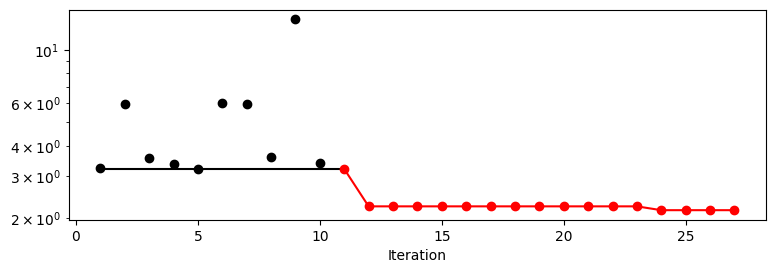

In [11]:
spot_tuner.plot_progress(log_y=True, filename=None)

Results can also be printed in tabular form.

In [12]:
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name                   | type   | default          |   lower |   upper | tuned                | transform              |   importance | stars   |
|------------------------|--------|------------------|---------|---------|----------------------|------------------------|--------------|---------|
| grace_period           | int    | 200              |    10.0 |  1000.0 | 41.0                 | None                   |         0.00 |         |
| max_depth              | int    | 20               |     2.0 |    20.0 | 11.0                 | transform_power_2_int  |         0.00 |         |
| delta                  | float  | 1e-07            |   1e-08 |   1e-06 | 1e-06                | None                   |         0.25 | .       |
| tau                    | float  | 0.05             |    0.01 |     0.1 | 0.029762022410147075 | None                   |         0.05 |         |
| leaf_prediction        | factor | mean             |     0.0 |     2.0 | model                | None          

A histogram can be used to visualize the most important hyperparameters.

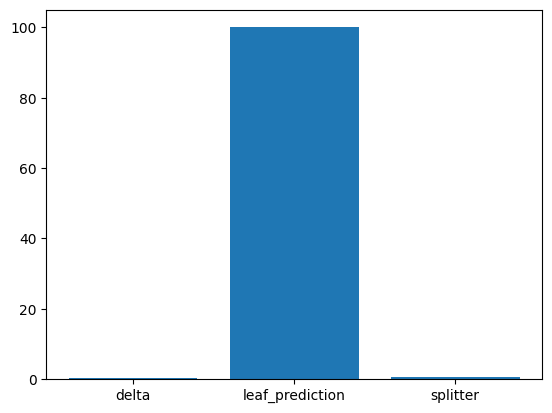

In [33]:
spot_tuner.plot_importance(threshold=0.1)

## Get Default Hyperparameters

The default hyperparameters, which will be used for a comparion with the tuned hyperparameters, can be obtained with the following commands:

In [14]:
from spotpython.hyperparameters.values import get_one_core_model_from_X
from spotpython.hyperparameters.values import get_default_hyperparameters_as_array
X_start = get_default_hyperparameters_as_array(fun_control)
model_default = get_one_core_model_from_X(X_start, fun_control, default=True)
model_default

HoeffdingTreeRegressor (
  grace_period=200
  max_depth=1048576
  delta=1e-07
  tau=0.05
  leaf_prediction="mean"
  leaf_model=LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
  model_selector_decay=0.95
  nominal_attributes=None
  splitter=EBSTSplitter ()
  min_samples_split=5
  binary_split=0
  max_size=500.
  memory_estimate_period=1000000
  stop_mem_management=0
  remove_poor_attrs=0
  merit_preprune=1
)

:::{.callout-note}
#### Note: `spotpython` tunes numpy arrays
* `spotpython` tunes numpy arrays, i.e., the hyperparameters are stored in a numpy array.
::::

The model with the default hyperparameters can be trained and evaluated with the following commands:

In [15]:
from spotriver.evaluation.eval_bml import eval_oml_horizon

df_eval_default, df_true_default = eval_oml_horizon(
                    model=model_default,
                    train=fun_control["train"],
                    test=fun_control["test"],
                    target_column=fun_control["target_column"],
                    horizon=fun_control["horizon"],
                    oml_grace_period=fun_control["oml_grace_period"],
                    metric=fun_control["metric_sklearn"],
                )

The three performance criteria, i.e., score (metric), runtime, and memory consumption, can be visualized with the following commands:

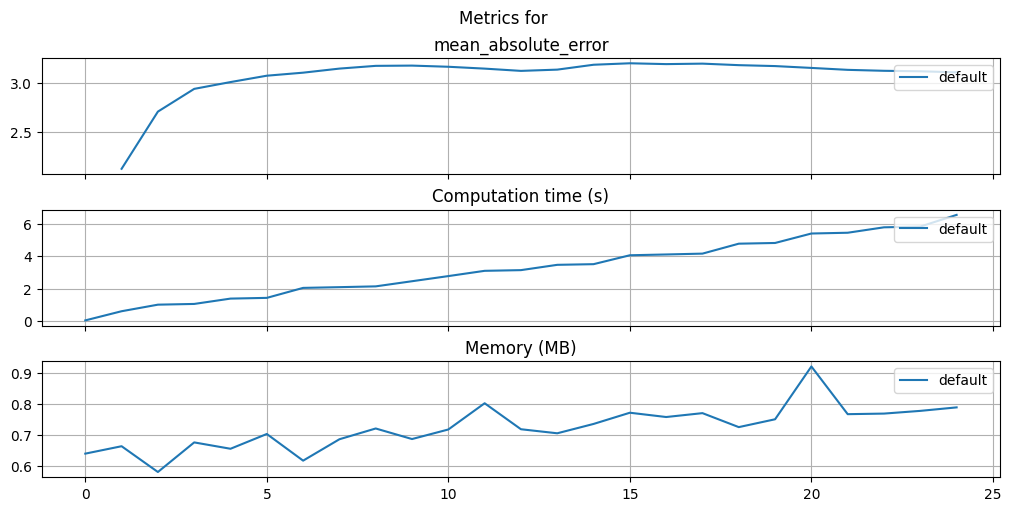

In [16]:
#| label: 024_plot_bml_oml_horizon_metrics_default
from spotriver.evaluation.eval_bml import plot_bml_oml_horizon_metrics, plot_bml_oml_horizon_predictions
df_labels=["default"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_default], log_y=False, df_labels=df_labels, metric=fun_control["metric_sklearn"])

### Show Predictions

* Select a subset of the data set for the visualization of the predictions:
    * We use the mean, $m$, of the data set as the center of the visualization.
    * We use 100 data points, i.e., $m \pm 50$ as the visualization window.

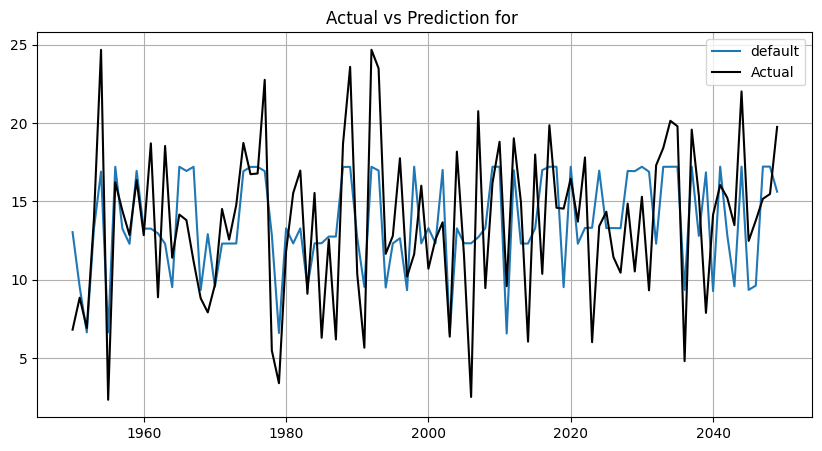

In [17]:
#| label: 024_plot_bml_oml_horizon_predictions_default
m = fun_control["test"].shape[0]
a = int(m/2)-50
b = int(m/2)+50
plot_bml_oml_horizon_predictions(df_true = [df_true_default[a:b]], target_column=target_column,  df_labels=df_labels)

## Get SPOT Results

In a similar way, we can obtain the hyperparameters found by `spotpython`.

In [18]:
#| label: 024_get_one_core_model_from_X
from spotpython.hyperparameters.values import get_one_core_model_from_X
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
model_spot = get_one_core_model_from_X(X, fun_control)

In [19]:
#| label: 024_eval_om_horizon
df_eval_spot, df_true_spot = eval_oml_horizon(
                    model=model_spot,
                    train=fun_control["train"],
                    test=fun_control["test"],
                    target_column=fun_control["target_column"],
                    horizon=fun_control["horizon"],
                    oml_grace_period=fun_control["oml_grace_period"],
                    metric=fun_control["metric_sklearn"],
                )

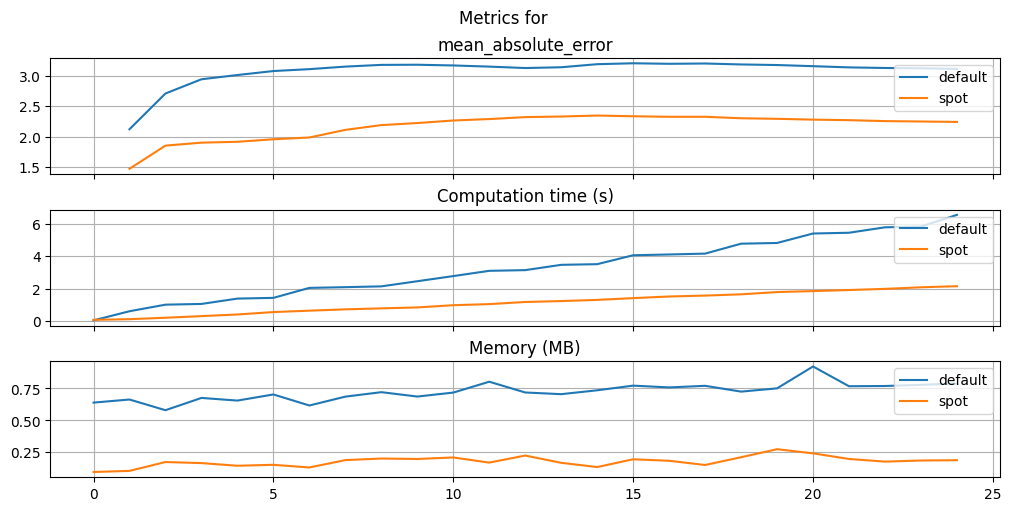

In [20]:
#| label: 024_plot_bml_oml_horizon_metrics
df_labels=["default", "spot"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_default, df_eval_spot], log_y=False, df_labels=df_labels, metric=fun_control["metric_sklearn"])

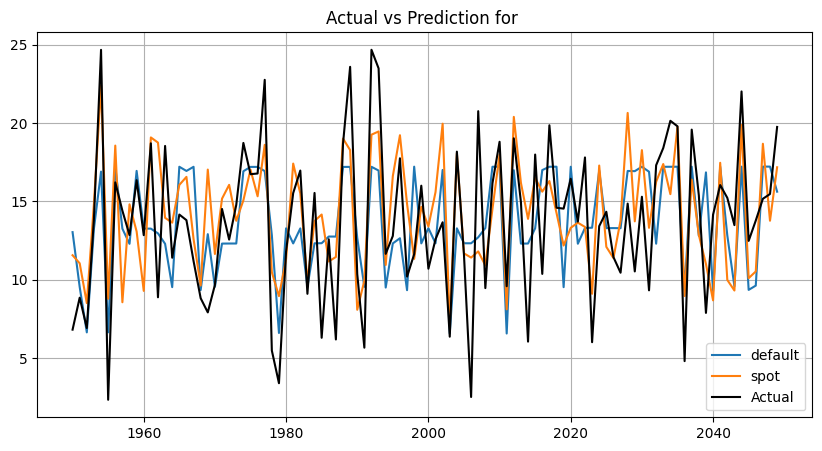

In [21]:
#| label: 024_plot_bml_oml_horizon_predictions
plot_bml_oml_horizon_predictions(df_true = [df_true_default[a:b], df_true_spot[a:b]], target_column=target_column,  df_labels=df_labels)

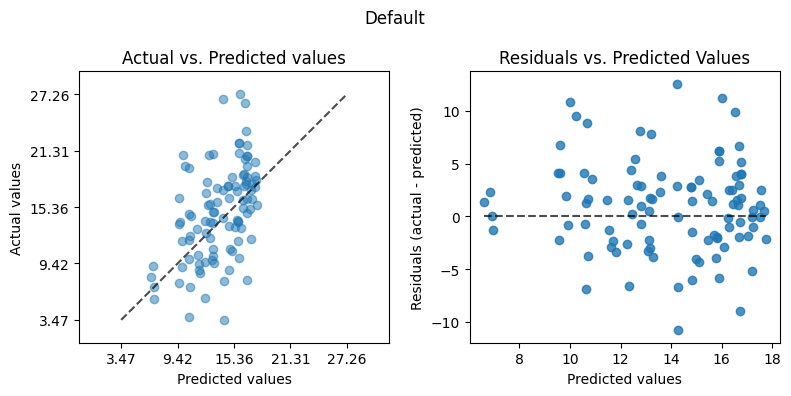

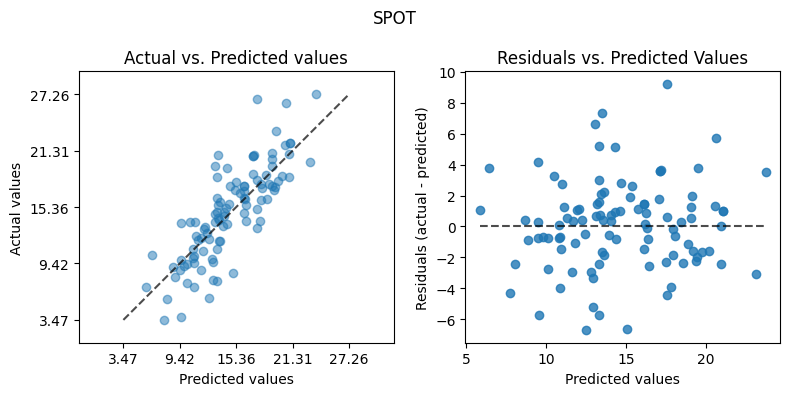

In [22]:
#| label: 024_plot_actual_vs_predicted
from spotpython.plot.validation import plot_actual_vs_predicted
plot_actual_vs_predicted(y_test=df_true_default[target_column], y_pred=df_true_default["Prediction"], title="Default")
plot_actual_vs_predicted(y_test=df_true_spot[target_column], y_pred=df_true_spot["Prediction"], title="SPOT")

## Visualize Regression Trees

In [23]:
#| label: 024_model_default_learn_one
dataset_f = dataset.take(n_samples)
print(f"n_samples: {n_samples}")
for x, y in dataset_f:
    model_default.learn_one(x, y)

n_samples: 10000


:::{.callout-caution}
### Caution: Large Trees
* Since the trees are large, the visualization is suppressed by default.
* To visualize the trees, uncomment the following line.
:::

In [24]:
# model_default.draw()

In [25]:
#| label: 024_model_default_summary
model_default.summary

{'n_nodes': 23,
 'n_branches': 11,
 'n_leaves': 12,
 'n_active_leaves': 12,
 'n_inactive_leaves': 0,
 'height': 7,
 'total_observed_weight': 14168.0}

### Spot Model

In [26]:
#| label: 024_model_spot_learn_one
print(f"n_samples: {n_samples}")
dataset_f = dataset.take(n_samples)
for x, y in dataset_f:
    model_spot.learn_one(x, y)

n_samples: 10000


:::{.callout-caution}
### Caution: Large Trees
* Since the trees are large, the visualization is suppressed by default.
* To visualize the trees, uncomment the following line.
:::

In [27]:
# model_spot.draw()

In [28]:
#| label: 024_model_spot_summary
model_spot.summary

{'n_nodes': 63,
 'n_branches': 31,
 'n_leaves': 32,
 'n_active_leaves': 32,
 'n_inactive_leaves': 0,
 'height': 9,
 'total_observed_weight': 14168.0}

In [29]:
#| label: 024_compare_two_tree_models
from spotpython.utils.eda import compare_two_tree_models
print(compare_two_tree_models(model_default, model_spot))

| Parameter             |   Default |   Spot |
|-----------------------|-----------|--------|
| n_nodes               |        23 |     63 |
| n_branches            |        11 |     31 |
| n_leaves              |        12 |     32 |
| n_active_leaves       |        12 |     32 |
| n_inactive_leaves     |         0 |      0 |
| height                |         7 |      9 |
| total_observed_weight |     14168 |  14168 |


## Detailed Hyperparameter Plots

grace_period:  0.0017349552954568275
max_depth:  0.0017349552954568275
delta:  0.2475472928535147
tau:  0.04884532128326959
leaf_prediction:  100.0
leaf_model:  0.0017349552954568275
model_selector_decay:  0.07705551838352352
splitter:  0.5192237851235003
min_samples_split:  0.0017349552954568275
binary_split:  0.004231019603346992
max_size:  0.0017349552954568275
memory_estimate_period:  0.0017349552954568275
stop_mem_management:  0.0017349552954568275
remove_poor_attrs:  0.0017349552954568275
merit_preprune:  0.0017349552954568275
impo: [['grace_period', 0.0017349552954568275], ['max_depth', 0.0017349552954568275], ['delta', 0.2475472928535147], ['tau', 0.04884532128326959], ['leaf_prediction', 100.0], ['leaf_model', 0.0017349552954568275], ['model_selector_decay', 0.07705551838352352], ['splitter', 0.5192237851235003], ['min_samples_split', 0.0017349552954568275], ['binary_split', 0.004231019603346992], ['max_size', 0.0017349552954568275], ['memory_estimate_period', 0.00173495529545

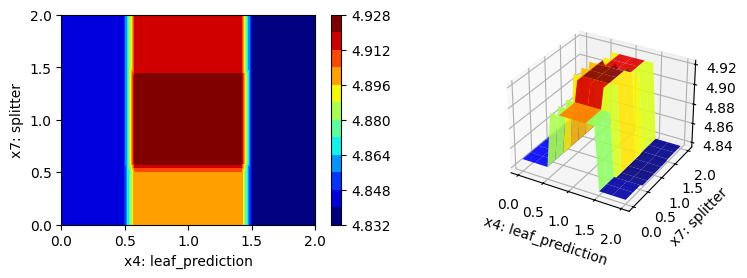

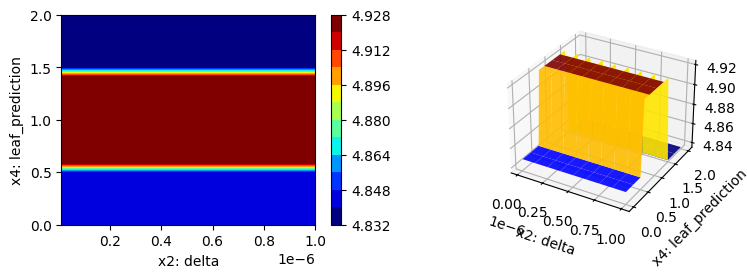

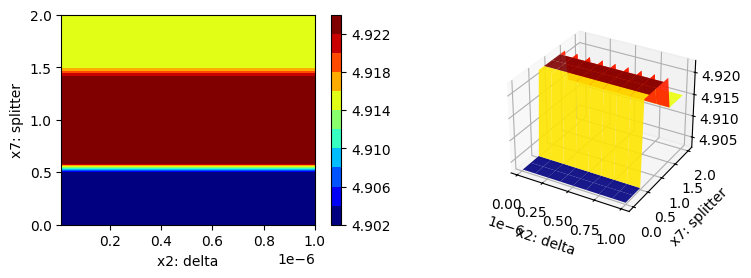

In [30]:
#| label: 024_plot_important_hyperparameter_contour
spot_tuner.plot_important_hyperparameter_contour(max_imp=3)

## Parallel Coordinates Plots

In [31]:
#| label: 024_parallel_plot
spot_tuner.parallel_plot()